<a href="https://colab.research.google.com/github/FidelM345/FoodPredictor/blob/main/FoodPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Food classes using Transfer Learning.

In [1]:
#Check whether we ar using a gpu
!nvidia-smi

Mon Oct 11 11:32:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import the helper functions file in our notebook.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-11 11:32:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-11 11:32:15 (72.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import a series of helper functions in our notebook.
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir


# 101 Food Classes: Working with less data
the goal for this experiment is to beat the original Food101 paper. The model in the research paper was created using an ML model Random Forest and had an average accuracy of about 53 %.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-10-11 11:32:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  87.3MB/s    in 18s     

2021-10-11 11:32:36 (86.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
#Unzip the data.
!unzip 101_food_classes_10_percent.zip

In [6]:
#check how many images/ classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 imag

In [7]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [8]:
# set up the data inputs
import tensorflow as tf

IMG_SIZE =(224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False #dont shuffle for preiction analysis
)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Model Training steps:

*   Create a ModelCheckPoint callback
*   Create a data augmentation layer 
*   Create a Fucntional Model without a classification layer
*    Compile the model
* Feature extract for 5 full passes ( 5 epochs on train dataset and validate on 15% of test data to save epoch time)

In [9]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only = True,
    monitor = "val_accuracy",
    save_best_only = True #will save the weights with the highest accuracy
)

In [10]:
# Create data augmentation layer to incoproate right into your model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation = Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      preprocessing.RandomZoom(0.2),
     # preprocessing.Rescaling(1/255.) #rescale inputs of images between 0-1 not necessary for EfficientNet its built in already
], name="data_augmentation_layer")

In [11]:
# Set up the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) #augment images. this omly happen during training phase
x = base_model(x, training =False) #this will put the base model to inference mode so weights that need to be frozen will stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) #we use 2D because we are working with 2D images
outputs = layers.Dense(101,activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs,outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [12]:
# get a summary of the model we have created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
#Compile and fit the model
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_training_history_10_percent_data = model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.15* len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback(dir_name="tensor_board",
                                             experiment_name="foodpredictor_feature_extraction",
                                             ), checkpoint_callback]
)


Saving TensorBoard log files to: tensor_board/foodpredictor_feature_extraction/20211011-113319
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 156s 509ms/step - loss: 3.4722 - accuracy: 0.2433 - val_loss: 2.7686 - val_accuracy: 0.3724
Epoch 2/5
237/237 [==============================] - 93s 392ms/step - loss: 2.3439 - accuracy: 0.4634 - val_loss: 2.3272 - val_accuracy: 0.4433
Epoch 3/5
237/237 [==============================] - 85s 357ms/step - loss: 1.9857 - accuracy: 0.5249 - val_loss: 2.1365 - val_accuracy: 0.4698
Epoch 4/5
237/237 [==============================] - 81s 338ms/step - loss: 1.7564 - accuracy: 0.5787 - val_loss: 2.0218 - val_accuracy: 0.4915
Epoch 5/5
237/237 [==============================] - 73s 304ms/step - loss: 1.5949 - accuracy: 0.6088 - val_loss: 1.9668 - val_accuracy: 0.4981


In [14]:
#evalute our model
model.evaluate(test_data_10_percent)

790/790 [==============================] - 102s 129ms/step - loss: 1.7160 - accuracy: 0.5546


[1.7159924507141113, 0.5545742511749268]

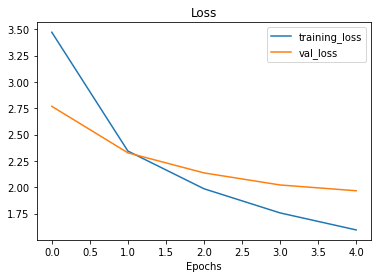

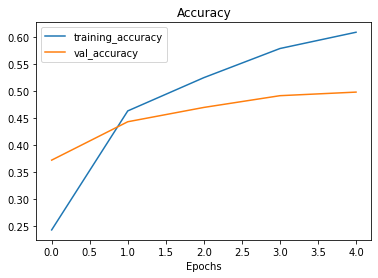

In [15]:
# plot the loss and accuracy curves
plot_loss_curves(model_training_history_10_percent_data)

## Fine tunig our FoodPredictor Model

In [16]:
# unfreeze all layers in the base model
base_model.trainable = True

# Refreeze all the layers except for the last 5 layers. unfreeze few layers for training
# incases where the feature extraction model performs well
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [17]:
# recompile the model with lower learning rate when fine tuning the best practise
# is to reduce by x10.
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
# what layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [19]:
#check the trainable layers in our efficientnet base model.
for num, layer in enumerate(model.layers[2].layers):
  print(num,layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 #because we have added to the intial 5 epochs during featue extraction TL.

fine_tuning_training_history = model.fit(
    train_data_10_percent,
    epochs = fine_tune_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.15* len(test_data_10_percent)),
    initial_epoch=model_training_history_10_percent_data.epoch[-1]
)


Epoch 5/10
237/237 [==============================] - 84s 317ms/step - loss: 1.3561 - accuracy: 0.6503 - val_loss: 1.9275 - val_accuracy: 0.5069
Epoch 6/10
237/237 [==============================] - 73s 305ms/step - loss: 1.2290 - accuracy: 0.6752 - val_loss: 1.9197 - val_accuracy: 0.5085
Epoch 7/10
237/237 [==============================] - 72s 302ms/step - loss: 1.1472 - accuracy: 0.6947 - val_loss: 1.9145 - val_accuracy: 0.5090
Epoch 8/10
237/237 [==============================] - 67s 283ms/step - loss: 1.0889 - accuracy: 0.7101 - val_loss: 1.9554 - val_accuracy: 0.5024
Epoch 9/10
237/237 [==============================] - 65s 270ms/step - loss: 1.0285 - accuracy: 0.7267 - val_loss: 1.9362 - val_accuracy: 0.5117
Epoch 10/10
237/237 [==============================] - 63s 263ms/step - loss: 0.9697 - accuracy: 0.7476 - val_loss: 1.9480 - val_accuracy: 0.5016


In [21]:
model.evaluate(test_data_10_percent)

790/790 [==============================] - 102s 128ms/step - loss: 1.6053 - accuracy: 0.5815


[1.6053014993667603, 0.5815445780754089]

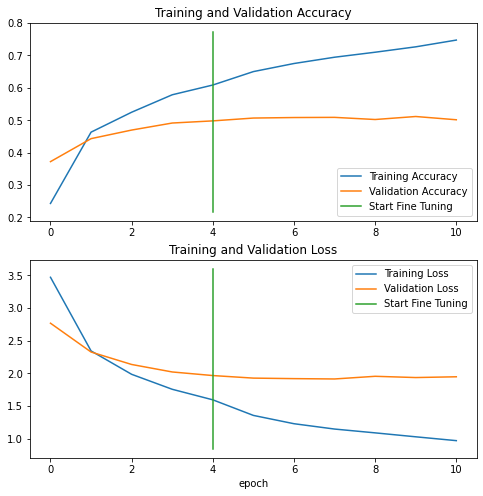

In [22]:
compare_historys(original_history=model_training_history_10_percent_data,
                 new_history=fine_tuning_training_history,
                 initial_epochs=5)

## Save an loading our models

To use our model in an external application we will need to save it an export it somewhere.


In [23]:
# save our fine-tuned model in google drive. But first u will have 
# to mount google drive in google colab.
model.save("drive/MyDrive/foodpredictor/foodpredictor_model")

INFO:tensorflow:Assets written to: drive/MyDrive/foodpredictor/foodpredictor_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [24]:
#load the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/foodpredictor/foodpredictor_model")

In [25]:
loaded_model_results = loaded_model.evaluate(test_data_10_percent)
loaded_model_results

790/790 [==============================] - 105s 131ms/step - loss: 1.6053 - accuracy: 0.5815


[1.6053014993667603, 0.5815445780754089]

## Evaluating  the performance of our model across different classes.

In [69]:
#Making predictions with model
prediction_probability = loaded_model.predict(test_data_10_percent, verbose=1)

790/790 [==============================] - 89s 113ms/step


In [70]:
# How many predictions are there ?  #there is a single prediction for every test image.
len(prediction_probability)

25250

In [71]:
#whats the shape of our pediction. Every image prediction is made up of 101 classes.
#this is because we are using the softmax activation function
prediction_probability.shape

(25250, 101)

In [29]:
#Lets see how the first 10 prediction look like
prediction_probability[:10]

array([[4.4595203e-01, 4.4342571e-05, 1.1000416e-01, ..., 6.1312428e-05,
        1.4688710e-03, 3.9916053e-02],
       [7.4546707e-01, 6.5966026e-07, 4.1312585e-03, ..., 1.4493163e-03,
        1.2578608e-06, 2.3859604e-06],
       [1.3985538e-01, 5.3949216e-03, 9.6986424e-03, ..., 9.8938984e-04,
        1.6988736e-03, 2.3597572e-03],
       ...,
       [1.2739243e-01, 9.3069793e-06, 1.1921776e-03, ..., 2.7328327e-02,
        1.1710800e-03, 3.5880461e-05],
       [1.3336064e-01, 8.6223852e-04, 8.2632951e-02, ..., 1.1473070e-03,
        2.0639987e-04, 3.6273361e-04],
       [4.2625526e-01, 4.8506990e-06, 8.2399510e-04, ..., 1.9203248e-02,
        1.6265891e-05, 3.3702541e-03]], dtype=float32)

In [30]:
# How does the first prediction_probability array look like.
prediction_probability[0], len(prediction_probability[0]), sum(prediction_probability[0]) #sum should be 1 or very close to 1.

(array([4.45952028e-01, 4.43425706e-05, 1.10004157e-01, 1.56448337e-07,
        2.68126246e-06, 3.00994475e-06, 7.61606861e-05, 1.57514714e-05,
        4.14310247e-02, 4.94618842e-04, 9.66634889e-06, 1.64411940e-05,
        1.91027008e-03, 2.24208043e-06, 1.45887835e-02, 1.99212041e-03,
        1.44514552e-05, 1.96732371e-03, 5.18371933e-04, 6.18946706e-06,
        2.07029734e-04, 3.81529499e-05, 4.73094318e-04, 1.65210789e-04,
        1.15185417e-03, 1.75152533e-03, 3.18683044e-04, 4.47311540e-05,
        1.28399238e-01, 4.78008855e-03, 1.71407294e-06, 1.39814464e-03,
        4.48721315e-04, 2.45841591e-07, 1.59382150e-02, 2.84819453e-05,
        7.65309160e-05, 1.15915912e-03, 1.37906270e-02, 1.33619760e-04,
        1.23177320e-04, 1.74560712e-03, 1.67044403e-03, 3.26871327e-06,
        1.84038625e-04, 5.58523388e-05, 3.70236958e-04, 2.34963984e-04,
        2.33386390e-06, 1.64823625e-02, 1.70063914e-03, 3.30701514e-05,
        2.96392124e-02, 1.54092154e-02, 5.19956993e-05, 2.089670

In [31]:
# The class with highest propability for sample o has a percentage of:
# argmax() function returns the index of the element in the array with the highest value.
print(f"the prediction is: {prediction_probability[0][prediction_probability[0].argmax()]}")

the prediction is: 0.44595202803611755


In [32]:
test_data_10_percent.class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [33]:
# get the class name of with the highest probability prediction.
test_data_10_percent.class_names[tf.argmax(prediction_probability[0])]

'apple_pie'

**Note:** Rank, dimension and axis are terms with similar meanings. A scalar has rank 0, a vector has rank 1, a matrix is rank 2.

In [34]:
# Gettting prediction classes for each of the test samples.
prediction_classes = prediction_probability.argmax(axis=1)
prediction_classes.shape, prediction_classes[:10]


((25250,), array([ 0,  0,  0,  8, 29, 78, 29, 46,  9,  0]))

In [35]:
# How many pred classes do we have
len(prediction_classes)

25250

To evaluate our model prediction results we must compare the model classes prediction results with the original test dataset labels.


In [36]:
# To get the test labels we need to unbatch our test_data BatchDataset
y_label = []

for images, labels in test_data_10_percent.unbatch():
  y_label.append(labels.numpy().argmax()) #the test labels are one-hot encoded
y_label[:10]

#since we turned our shuffle of for our test dataset it means they are in the same order as our 
#model prediction hence we can compare the first 10 elements in our model prediction resulst with
#the first 10 labels in our original test dataset

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:

print(f"Classes predicted by model {prediction_classes[:10]}, shape is {prediction_classes.shape}")
print(f"True labels from test data {y_label[:10]}, shape is {len(y_label)}")

Classes predicted by model [ 0  0  0  8 29 78 29 46  9  0], shape is (25250,)
True labels from test data [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], shape is 25250


## Let's try the scikit-learn accuracy score function and determine what it comes up with.

In [38]:
from sklearn.metrics import  accuracy_score
sklearn_accuracy = accuracy_score(
    y_true = y_label,
    y_pred = prediction_classes
)

sklearn_accuracy #Its close to our model evaluation prediction results.

0.5815445544554455

## Let's make a confusion matrix

In [39]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#making changes to our confusion matrix to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #Changes (plot x-label appear vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [40]:

make_confusion_matrix(
       y_true = y_label,
       y_pred = prediction_classes,
       classes=test_data_10_percent.class_names,
       figsize=(150,150),
       text_size=25,
       savefig=True
)

## Generating a classification report using sklearn 
sklearn has a helpful function for acquiring many different classification metrics such as precision, recall and F1 called [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)


In [41]:
# The highest number for each of the metrics is 1 and the lowest is 0.
# The higher the value the better the performance.
#  F1-score is a combination of precision and recall.
from sklearn.metrics import classification_report
print(classification_report(
    y_true = y_label,
    y_pred = prediction_classes
))


              precision    recall  f1-score   support

           0       0.39      0.12      0.19       250
           1       0.54      0.67      0.60       250
           2       0.69      0.51      0.59       250
           3       0.84      0.44      0.58       250
           4       0.48      0.47      0.48       250
           5       0.44      0.32      0.37       250
           6       0.81      0.70      0.75       250
           7       0.81      0.70      0.75       250
           8       0.22      0.57      0.32       250
           9       0.37      0.62      0.46       250
          10       0.44      0.46      0.45       250
          11       0.77      0.55      0.64       250
          12       0.72      0.52      0.61       250
          13       0.60      0.50      0.54       250
          14       0.70      0.37      0.49       250
          15       0.37      0.38      0.37       250
          16       0.72      0.46      0.56       250
          17       0.31    

The numbers above give a great class by class evaluation of our models prediction, but with so many classes they are quite hard to understand. What if we visualize the classes to get a better understanding. 

In [42]:
# Get a dictionary of the classification report
classification_report_dictionary = classification_report(y_true=y_label,
                                                         y_pred=prediction_classes,
                                                         output_dict=True)
classification_report_dictionary


{'0': {'f1-score': 0.1884498480243161,
  'precision': 0.3924050632911392,
  'recall': 0.124,
  'support': 250},
 '1': {'f1-score': 0.5974955277280859,
  'precision': 0.540453074433657,
  'recall': 0.668,
  'support': 250},
 '10': {'f1-score': 0.45312500000000006,
  'precision': 0.44274809160305345,
  'recall': 0.464,
  'support': 250},
 '100': {'f1-score': 0.6623376623376623,
  'precision': 0.7216981132075472,
  'recall': 0.612,
  'support': 250},
 '11': {'f1-score': 0.6416861826697893,
  'precision': 0.7740112994350282,
  'recall': 0.548,
  'support': 250},
 '12': {'f1-score': 0.6078886310904873,
  'precision': 0.7237569060773481,
  'recall': 0.524,
  'support': 250},
 '13': {'f1-score': 0.5426695842450766,
  'precision': 0.5990338164251208,
  'recall': 0.496,
  'support': 250},
 '14': {'f1-score': 0.486910994764398,
  'precision': 0.7045454545454546,
  'recall': 0.372,
  'support': 250},
 '15': {'f1-score': 0.37426900584795325,
  'precision': 0.3650190114068441,
  'recall': 0.384,
  

### Let's plot all our classes F1-scores

In [43]:
class_f1_scores ={}
f1_scores=[]
for key, value in classification_report_dictionary.items():
  if key == "accuracy": #stop once we get to accuracy key
    break
  else:
    #Add class_names and F1-scores to the new dictionary
    class_f1_scores[test_data_10_percent.class_names[int(key)]]=value["f1-score"] #the int() converts string to integer
    f1_scores = value["f1-score"]

class_f1_scores

{'apple_pie': 0.1884498480243161,
 'baby_back_ribs': 0.5974955277280859,
 'baklava': 0.5852534562211982,
 'beef_carpaccio': 0.581151832460733,
 'beef_tartare': 0.47560975609756095,
 'beet_salad': 0.37241379310344824,
 'beignets': 0.7494646680942184,
 'bibimbap': 0.7494646680942184,
 'bread_pudding': 0.32207207207207206,
 'breakfast_burrito': 0.46497764530551416,
 'bruschetta': 0.45312500000000006,
 'caesar_salad': 0.6416861826697893,
 'cannoli': 0.6078886310904873,
 'caprese_salad': 0.5426695842450766,
 'carrot_cake': 0.486910994764398,
 'ceviche': 0.37426900584795325,
 'cheese_plate': 0.5609756097560976,
 'cheesecake': 0.3935860058309038,
 'chicken_curry': 0.46370023419203743,
 'chicken_quesadilla': 0.6265560165975104,
 'chicken_wings': 0.7007575757575757,
 'chocolate_cake': 0.5598526703499079,
 'chocolate_mousse': 0.3382663847780127,
 'churros': 0.722466960352423,
 'clam_chowder': 0.6808510638297872,
 'club_sandwich': 0.688259109311741,
 'crab_cakes': 0.3529411764705882,
 'creme_brul

In [44]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

dataframe = pd.DataFrame({
    "class_names":list(class_f1_scores.keys()),
    "f1-scores": list(class_f1_scores.values())
}).sort_values("f1-scores", ascending=False)

In [45]:
dataframe[:10]

class_names  f1-scores
33            edamame   0.953307
63           macarons   0.870690
86            sashimi   0.830339
51          guacamole   0.818356
45      frozen_yogurt   0.816842
75                pho   0.813869
54  hot_and_sour_soup   0.811245
69            oysters   0.809717
32          dumplings   0.802303
64          miso_soup   0.796330

In [46]:
len(dataframe)

101

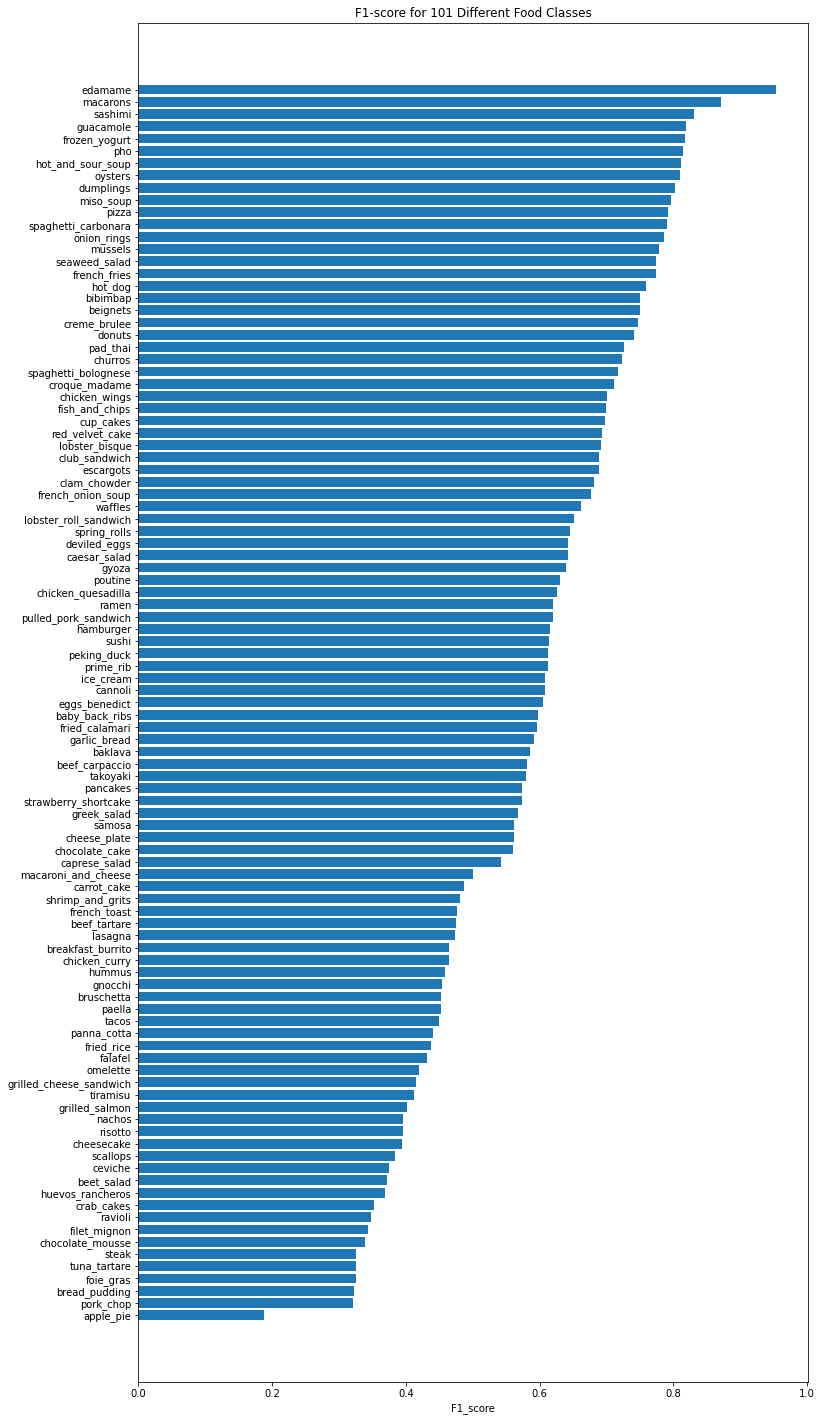

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(dataframe)), dataframe["f1-scores"].values) #get f1-scores values
ax.set_yticks(range(len(dataframe)))
ax.set_yticklabels(dataframe["class_names"])
ax.set_xlabel("F1_score")
ax.set_title("F1-score for 101 Different Food Classes")
ax.invert_yaxis(); #Inverts the order of our plots. i.e it will start with the class with highest F1-value


## Visualizing prediction on both test and custom images. <br>
**Custom Images:** These are images not present both in the test and training dataset. <br>
To  visualize or model's prediction on our own images. We will need a function that will load and preprocess our images. That is, we can only make predictions on data that is of the same format, type or tensor shape that the model was trained on. <br>
To achieve the goal follow the following steps:
<br>
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size a the images our model has trained on using `tf.image.resize()`
* Scale the image pixel values to be between 0-1 (if necessary). If u use models such as EfficientNet it has an inbuilt scaling capability hence this step is not mandatory.


In [48]:
# Create a function to load and preprocess our images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Read in the image from a filename, and truns it into a tensor and reshapes into 
  a specified shape (img_shape,img_shape,color_channels=3)
  
  Args:
    filename(str): path to target iamge
    image_shape(int): height and width dimensions of the target image
    scale(bool): scale pixes values from 0-255 to 0-1 or not.

    Returns:
      Image tensor of shape (image_shape,Imag_shape,3)
  """
  #Read in the image file
  img = tf.io.read_file(filename)

  #Decode the image into a tensor
  #by manually writing our channel is 3 we will ensure that if our image is png
  # which is a 4 channel image it will still be converted into 3 channels otherwise an error
  # will be thrown if we read a png without explicitly assigning a channel value of 3
  img = tf.io.decode_image(img, channels=3)

  #Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  #Scale your image yes or no
  if scale:
    #rescale your image to between 0-1
    return img/255.
  else:
    return img



We have successfuly created a function to laod and preprocess our images. So we are going to write some code to visualize our images, their target label and our model predictions.

Specifically, we will write some code to:
1.   Load a few random images from our test dataset.
2.   Make predictions on the loaded images.
3. Plot the original images(s) along with the modell's predictions, prediction probability and the truth label.





In [49]:
class_names = test_data_10_percent.class_names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

101_food_classes_10_percent/test/fried_calamari/854958.jpg
original image shape: (224, 224, 3)
expanded image shape: (1, 224, 224, 3)
(1, 101)
fried_calamari

101_food_classes_10_percent/test/scallops/1401468.jpg
original image shape: (224, 224, 3)
expanded image shape: (1, 224, 224, 3)
(1, 101)
hamburger

101_food_classes_10_percent/test/miso_soup/1161640.jpg
original image shape: (224, 224, 3)
expanded image shape: (1, 224, 224, 3)
(1, 101)
miso_soup



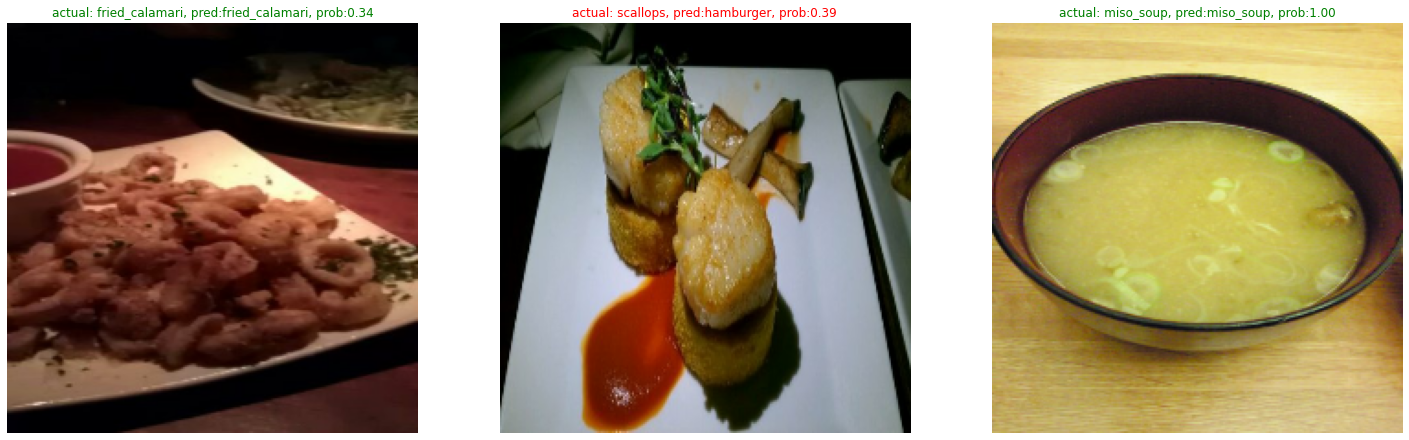

In [50]:
# Make preds on a series of random images
import os #used when dealing with files and folders in python
import random

plt.figure(figsize=(25,10))
for i in range(3):
  #choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name)) #the os.lidtdir will list all files in the target directory
  filepath = test_dir + class_name + "/"+ filename
  print(filepath)

  # Load image and make predictions
  img = load_and_prep_image(filename=filepath,img_shape=224, scale=False)
  print(f"original image shape: {img.shape}")
  # our model was trained on 4d images hence we must also enusre our image used for prediction is 4d
  # we will exand its dimension
  img_expanded = tf.expand_dims(img,axis=0)
  print(f"expanded image shape: {img_expanded.shape}")
  prediction_probability = model.predict(img_expanded) #get prediction probability arrays. We expand the dimension by 1 because our training dataset was in 4d
  pred_class = class_names[prediction_probability.argmax()] # get highest prediction prob index
  print(prediction_probability.shape)
  print(pred_class)
  print("")

  #Plot the images
  plt.subplot(1,3,i+1) #(rows,columns,indicies)
  plt.imshow(img/255.)

  if class_name == pred_class: #if the predicted class matches the truth class make title green
    title_color ="g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred:{pred_class}, prob:{prediction_probability.max():.2f}", c=title_color)
  plt.axis(False)

### Finding the most wrong predictions.

A good way to evaluate your model performance is by viewing model predictions which have high prediction probability but are infact wrong. 

Reasons for wrong predictions with high prediction probability can be caused by the following factors:
* Data issues (wrong dataset labelling. The model might be right in its prediction but the data label is wrong)
* Confusiing classes (To get better prediction results your dataset must be diverse)

To find out where our model is most wrong, follow the steps below:
1. Get all of the image file paths in the test dataset using the list_file() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and groundtruth classnames.
3. Use our DataFrame to find all the wrong predictions. That is, where the ground truth label will not math the model prediction.
4. Sort the  DataFrame based on the wrong predictions (Have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but the wrong prediction

In [54]:
# get all the image file paths in the test dataset.
filepaths = []

for filepath in test_data_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                      shuffle=False):
  filepaths.append(filepath.numpy()) #converts the tensor to numpy array and later appends the string to the list

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [80]:
# 2. Create da DataFrame of the different parameters for each of our test images.
import pandas as pd
pred_DataFrame = pd.DataFrame(
    {"img_path": filepaths,
     "y_true":y_label,
     "y_pred":prediction_classes,
     "pred_confidence":prediction_probability.max(axis=1),
     "y_true_classname":[class_names[i] for i in y_label],
     "y_pred_classname":[class_names[i] for i in prediction_classes]

    }

)

pred_DataFrame

img_path  ...         y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                apple_pie
1      b'/content/101_food_classes_10_percent/test/ap...  ...                apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...                apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...            bread_pudding
4      b'/content/101_food_classes_10_percent/test/ap...  ...                cup_cakes
...                                                  ...  ...                      ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...                  waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...                  waffles
25247  b'/content/101_food_classes_10_percent/test/wa...  ...         huevos_rancheros
25248  b'/content/101_food_classes_10_percent/test/wa...  ...                    steak
25249  b'/content/101_food_classes_10_percent/test/wa...  ...  grilled_cheese_sandwich

[25250 rows x 6 columns]

In [81]:
# Find out in our dataFrame which predictions are wrong
pred_DataFrame["pred_correct"] = pred_DataFrame["y_true"]==pred_DataFrame["y_pred"]
# The above code will add an column to our existing DataFrame.
pred_DataFrame.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...          True
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [86]:
# Sort our dataFrame to have most wrong predictions at the top
top_100_wrong = pred_DataFrame[pred_DataFrame["pred_correct"]==False].sort_values("pred_confidence", ascending=False)[:100]
top_100_wrong.head(9)

img_path  ...  pred_correct
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
14630  b'/content/101_food_classes_10_percent/test/ic...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
15826  b'/content/101_food_classes_10_percent/test/ma...  ...         False
22511  b'/content/101_food_classes_10_percent/test/sp...  ...         False
14300  b'/content/101_food_classes_10_percent/test/hu...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[9 rows x 7 columns]

Pandas(Index=11642, img_path=b'/content/101_food_classes_10_percent/test/garlic_bread/2957596.jpg', y_true=46, y_pred=10, pred_confidence=0.9919488430023193, y_true_classname='garlic_bread', y_pred_classname='bruschetta', pred_correct=False)
Pandas(Index=11041, img_path=b'/content/101_food_classes_10_percent/test/fried_rice/1461091.jpg', y_true=44, y_pred=51, pred_confidence=0.9913289546966553, y_true_classname='fried_rice', y_pred_classname='guacamole', pred_correct=False)
Pandas(Index=22203, img_path=b'/content/101_food_classes_10_percent/test/seaweed_salad/441102.jpg', y_true=88, y_pred=51, pred_confidence=0.9905803799629211, y_true_classname='seaweed_salad', y_pred_classname='guacamole', pred_correct=False)
Pandas(Index=20488, img_path=b'/content/101_food_classes_10_percent/test/ramen/766615.jpg', y_true=81, y_pred=75, pred_confidence=0.9895706176757812, y_true_classname='ramen', y_pred_classname='pho', pred_correct=False)
Pandas(Index=15359, img_path=b'/content/101_food_classes_10

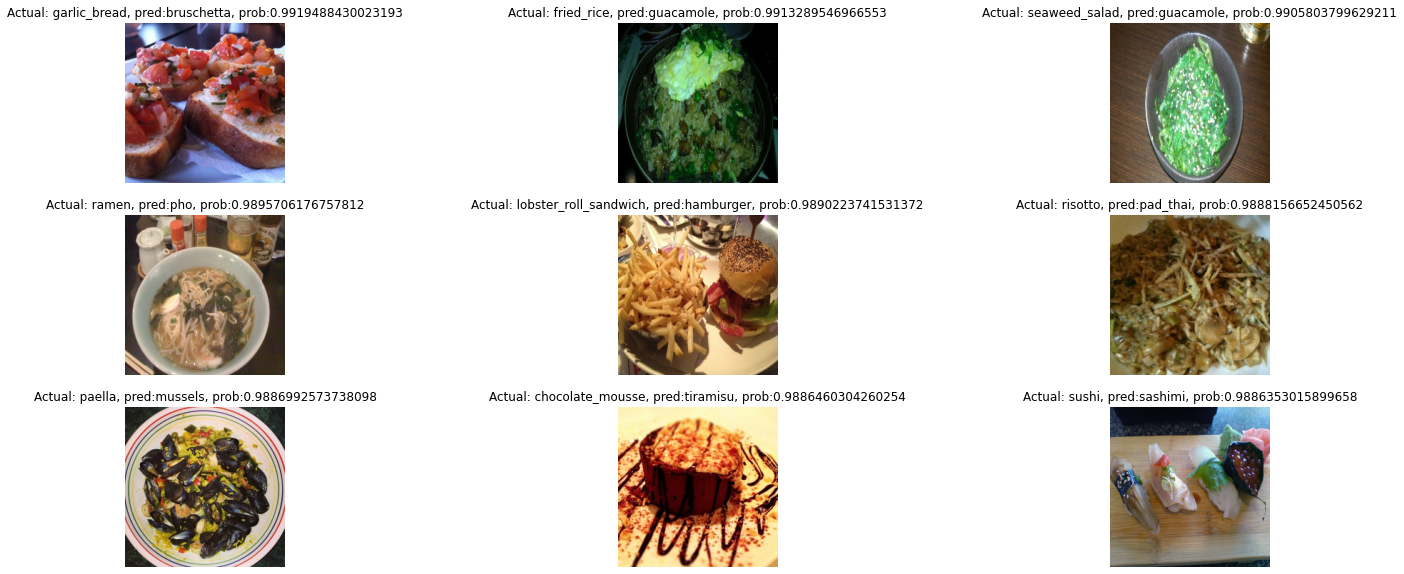

In [90]:
# Visualize the images that have been predicted wrongly by our model.
images_to_view = 9
start_index = 0 # you can change this value to view the different images in our dataset
plt.figure(figsize=(25,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  print(row)
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_,prediction_probability,y_true_classname,y_pred_classname,_=row #Only select the few parameters we are interested in. Skip those that are irrelevant
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, pred:{y_pred_classname}, prob:{prediction_probability}")
  plt.axis(False)


## Test our model on our own custom images

In [91]:
## Get custom images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2021-10-11 13:11:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  13.2MB/s    in 1.0s    

2021-10-11 13:11:43 (13.2 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
## unzip the custom images
!unzip custom_food_images.zip

In [95]:
##Get the custom food images filepaths
custom_food_images = ["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg']

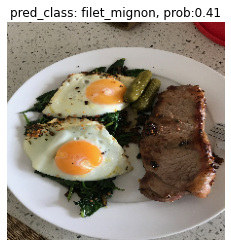

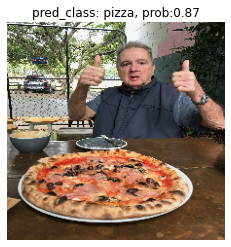

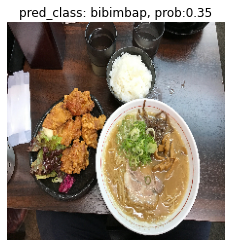

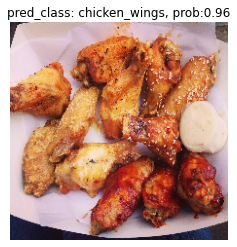

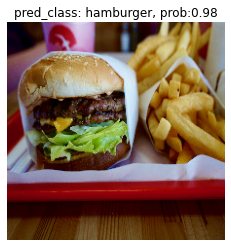

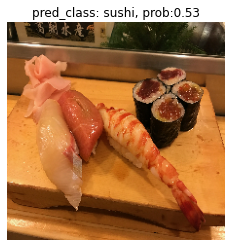

In [96]:
# Make predictions on  and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img,scale=False) #scale is False because we will use an EfficientNet model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) #make predictions on image with shape [1,224,224,3]
  pred_class = class_names[pred_prob.argmax()] # get the index with highest prediction probs

  #Plot the appropriate infor
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred_class: {pred_class}, prob:{pred_prob.max():.2f}")
  plt.axis(False)